In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from scipy.spatial import distance
from random import random
from sklearn.cluster import SpectralBiclustering
import itertools

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
from matplotlib import colors

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib
import scoring
import rda

In [2]:
## directory & file hierarchy
proj_dir = os.path.abspath('../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(analysis_dir,'results')
stim_dir = os.path.join(proj_dir,'stimuli')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [3]:
stim_dir

'/home/wmccarth/block_construction/stimuli'

In [4]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [33]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}_good.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}_good.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}_good.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

49 participants total


In [476]:
dfi.columns

Index(['Unnamed: 0', 'gameID', 'trialNum', 'phase', 'condition', 'eventType',
       'targetName', 'repetition', 'targetID', 'blockNum', 'nullScore',
       'incrementalScore', 'normedIncrementalScore', 'rawScoreDiscrete',
       'incrementalNormedScoreDiscretePrevious', 'score', 'currBonus',
       'timeAbsolute', 'timeRelative', 'timeBlockSelected', 'timeBlockPlaced',
       'relativePlacementTime', 'discreteWorld', 'vertices', 'blockKind',
       'blockColorID', 'blockColor', 'blockCenterX', 'blockCenterY', 'x_index',
       'y_index', 'x_discrete', 'y_discrete', 'width_discrete',
       'height_discrete', 'phase_extended', 'buggy', 'usableDiscreteWorld',
       'flatDiscreteWorld'],
      dtype='object')

## Actions

Placement of block: <w,h,x,y>

Only certain placements are possible at any one time: i.e. those just above the current tower (including in holes).

Consider set of actions as possible block placements *inside the silhouette* plus an error action- placing a block anywhere outside the silhouette.


In [8]:
blocks = np.array([[1,2],[2,1],[2,2],[2,4],[4,2]]) # block dimensions
locations = np.arange(0,8) # locations to place blocks- inside 8x8 grid only

### Maps of silhouette

In [7]:
target_dir = os.path.join(stim_dir,'hand_selected_e2_subset')

## load in list of structures
file_list = os.listdir(target_dir)
file_list = [x for x in file_list if not (x.startswith('.'))]

print('Loaded {} structures.'.format(len(file_list)))

target_blocks_dict = {}

## loop through list of good sequences, and build list of versions, each containing a trial list 
Meta = [] ## initialize list of all trial lists
for i,f in enumerate(file_list):
    target = pd.read_json(os.path.join(target_dir,f)) ## stim list
    targetName = f.split('.')[0]
    targetBlocks = list(target['blocks'].values)
    target_blocks_dict[targetName] = targetBlocks

Loaded 8 structures.


In [9]:
stimWidth = 8
worldWidth = 18
worldHeight = 13

target_maps = {}

for i, (target_name, block_list) in enumerate(target_blocks_dict.items()):
    #block_list = target_blocks_dict['hand_selected_009']
    target_map = np.zeros([worldWidth,worldHeight])

    for block in block_list:
        # add block to map
        width = block['width']
        height = block['height']
        blockLeft = int((worldWidth-stimWidth)/2) + block['x']
        blockBottom = block['y']
        blockTop = blockBottom + height
        blockRight = blockLeft + width

        #console.log('width', width);
        #console.log('height', height);
        #console.log('blockLeft', blockLeft);
        #console.log('blockBottom', blockBottom);
        for y in range(blockBottom,blockTop):
            for x in range(blockLeft, blockRight):
                target_map[x][y] = 1
    
    target_maps[target_name] = target_map
    

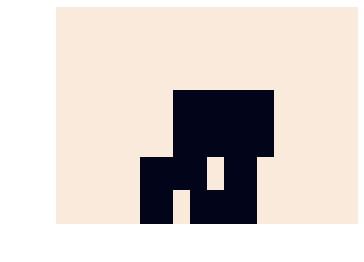

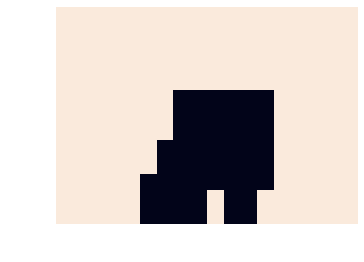

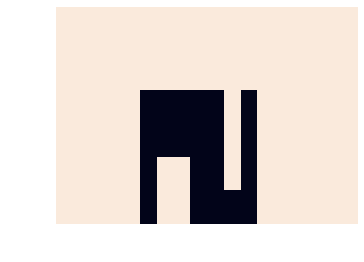

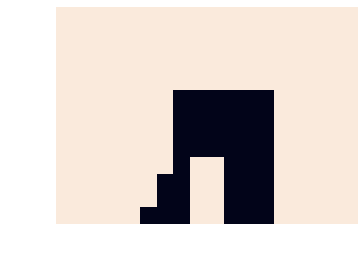

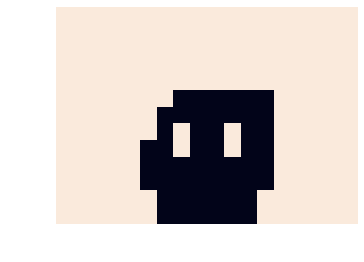

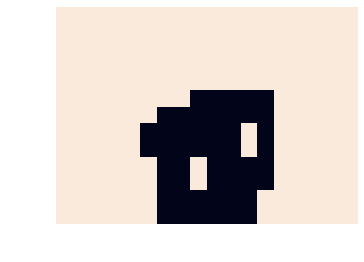

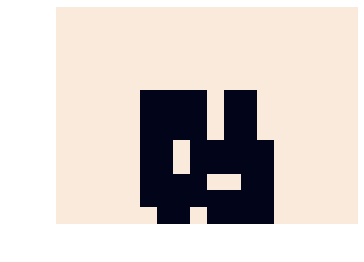

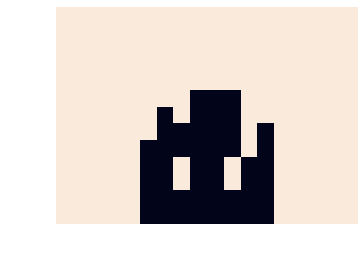

In [10]:
for i, (target_name, target_map) in enumerate(target_maps.items()):
    silhouette = 1*np.logical_not(target_map)
    silhouette = np.rot90(silhouette)
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.imshow(silhouette)

### Enumerate actions within silhouette

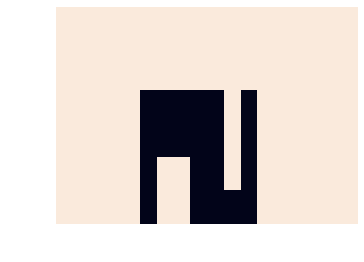

In [11]:
silhouette = 1*np.logical_not(target_maps['hand_selected_012'])
silhouette = np.rot90(silhouette)
fig, ax = plt.subplots()
ax.axis('off')
ax.imshow(silhouette)

In [12]:
tm = target_maps['hand_selected_012']

In [13]:
tm[5:12,0:8] # Slice only the silhouette

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 1., 1., 1., 1.]])

for a current world state:
find set of viable actions

iterate through layers (keep track of floors?)
for each block find viable locations
or 
for each location find viable blocks

some of these paths will lead to dead ends

## Actual distributions of human behavior

Look at the sequences of actions people actually take
And see how close they are
Do they end up closer (by rep 4)?

Similarity:
Closer if: 
Same blocks in same place
Same blocks in same placed placed at similar time

In [14]:
dfi['usableDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: 1+(-1)*np.array(ast.literal_eval(a)))
dfi['flatDiscreteWorld'] = dfi['discreteWorld'].apply(lambda a: (1+(-1)*np.array(ast.literal_eval(a))).flatten())

In [15]:
# We have sequences of world states, of length n where n is the number of blocks placed
# Each layer is a block placement
dfi['flatDiscreteWorld'][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Vector representing where blocks have been placed
Want to look at sequences of these
If people complete the silhouette, these vectors will be the same
Differing numbers of blocks mean the list of these vectors will be different lengths

## Discrete World State

In [ ]:
# get world state EVERY SECOND
# i.e. the flatDiscreteWorld for the highest time preceding i 
# for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,61,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*1000 < row['relativePlacementTime']) & ((i*1000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 60):
            m[t,p,i,:] = prev_world
            i += 1


In [ ]:
# get world state EVERY 10 SECONDS
# i.e. the flatDiscreteWorld for the highest time preceding i 
# PRE PHASE, for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m = np.zeros((n_targets,n_ppts,6,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='pre')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*10000 < row['relativePlacementTime']) & ((i*10000)<60000)):
                m[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 6):
            m[t,p,i,:] = prev_world
            i += 1


In [ ]:
# get world state EVERY 10 SECONDS
# i.e. the flatDiscreteWorld for the highest time preceding i 
# POST PHASE, for every participant, for every structure

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()

m2 = np.zeros((n_targets,n_ppts,6,13*18)) #number of seconds, number of squares in grid

for t, t_name in enumerate(targets):
    for p, p_id in enumerate(ppts):
        subset = dfi[(dfi.targetName==t_name) & (dfi.gameID==p_id) & (dfi.phase=='post')]
        prev_world = np.zeros(13*18)
        i = 0
        for index, row in subset.iterrows():
            while ((i*10000 < row['relativePlacementTime']) & ((i*10000)<60000)):
                m2[t,p,i,:] = prev_world
                i += 1
            prev_world = row['flatDiscreteWorld']
        while (i < 6):
            m2[t,p,i,:] = prev_world
            i += 1


In [ ]:
# (targets, participants, seconds, squares)
# for one target, get all participants
mat = m[3,:,50,:]

## Explore matrix creation (compare ppt world state for a given structure over time)

In [ ]:
# Create rdm for a given structure and time step (all ppts, one phase)

mat = m[3,:,1,:]
n_rows = mat.shape[0]

rdm = np.zeros((n_rows,n_rows))

for i in range (0, n_rows): # row dim
    for j in range (0, n_rows): # row dim
        rdm[i,j] = distance.euclidean(mat[i,:],mat[j,:])
        

img = plt.matshow(rdm)
img.set_cmap('hot')
plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.colorbar()

In [ ]:
# Use biclustering to arrange rows and columns. 
# This seems ok, except you have to specify the amount of clusters and the initial random state seems to have quite a large effect

mat = m[1,:,2,:]
n_rows = mat.shape[0]

rdm = np.zeros((n_rows,n_rows))

for i in range (0, n_rows): # row dim
    for j in range (0, n_rows): # row dim
        rdm[i,j] = distance.euclidean(mat[i,:],mat[j,:])

clustering = SpectralBiclustering(n_clusters=5, random_state=0).fit(rdm) # https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html
order = clustering.row_labels_

sorted_rdm = rdm[np.argsort(clustering.row_labels_)]
sorted_rdm = sorted_rdm[:, np.argsort(clustering.column_labels_)]

img1 = plt.matshow(rdm)
plt.axis('off')
plt.colorbar()
img2 = plt.matshow(sorted_rdm)
plt.axis('off')
img1.set_cmap('hot')
img2.set_cmap('hot')
plt.colorbar()

In [ ]:
importlib.reload(scoring)

In [ ]:
# Create and display RDMs for one structure (all ppts, one phase)

mat = m[3,:,:,:]

n_rows = mat.shape[0]
time_steps = mat.shape[1]

rdm = np.zeros((n_rows,n_rows, time_steps))

for step in range(0,time_steps):
    for i in range (0, n_rows): # row dim
        for j in range (0, n_rows): # row dim
            rdm[i,j,step] = scoring.get_jaccard(mat[i,step,:],mat[j,step,:])
        
for step in range(0,time_steps):
    img = plt.matshow(rdm[:,:,step])
    img.set_cmap('hot')
    plt.axis('off')
    plt.savefig("test.png", bbox_inches='tight')
    plt.colorbar()

## Sequences of world states by action

In [319]:
# Spread flatDiscreteWorld over columns

dfic = dfi[dfi.condition=='repeated']
dfic = dfic[['targetName','gameID','blockNum','repetition','flatDiscreteWorld']]

# Create index names
# for i in range(0,len(dfi['flatDiscreteWorld'][0])):
#     inds.append('w_' + str(i).zfill(3))

# Create columns from values in flatDiscreteWorld
world_cols = dfic.apply(lambda x: pd.Series(x['flatDiscreteWorld']), axis=1)
dfic = pd.concat([dfic, world_cols], axis=1)

In [320]:
# Make empty values for non-existent blockNums 

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())
max_actions = dfic['blockNum'].max()

# create multi-index
block_placement_index = (
    pd.MultiIndex
    .from_product(
        iterables=[targets, ppts, reps, range(1,max_actions + 1)],
        names=['targetName', 'gameID','repetition','blockNum']
    )
)

# set indexes, then replace with full product index, filling blank values with NaNs 
world_states = dfic.set_index(['targetName', 'gameID','repetition','blockNum']).\
    reindex(index=block_placement_index, fill_value=np.nan).reset_index()

In [366]:
# Get scores for each pair of repetitions

importlib.reload(scoring)

rep_pairs = list(combinations(reps,2))

def get_scores(x):
    tmp_df = pd.DataFrame(rep_pairs,
                          columns=['rep_a','rep_b'])
    #tmp_df = tmp_df.assign(score=lambda r: x[x.repetition==r.rep_a]['flatDiscreteWorld'])
    tmp_df['score'] = tmp_df.apply(lambda r: scoring.get_jaccard(\
                            x[x.repetition==r.rep_a].iloc[:,5:].values,\
                            x[x.repetition==r.rep_b].iloc[:,5:].values),\
                                                    axis=1)
    return tmp_df

scores_df = world_states.groupby(['targetName','gameID','blockNum']).apply(lambda x: get_scores(x))\
                               .reset_index()

In [365]:
rep_pairs = list(combinations(reps,2))
rep_pairs

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]

In [367]:
# Add convenient names for pairs of repeititons
scores_df['reps'] = scores_df.apply(lambda row: str(int(row.rep_a)) + ' to ' + str(int(row.rep_b)), axis = 1) 

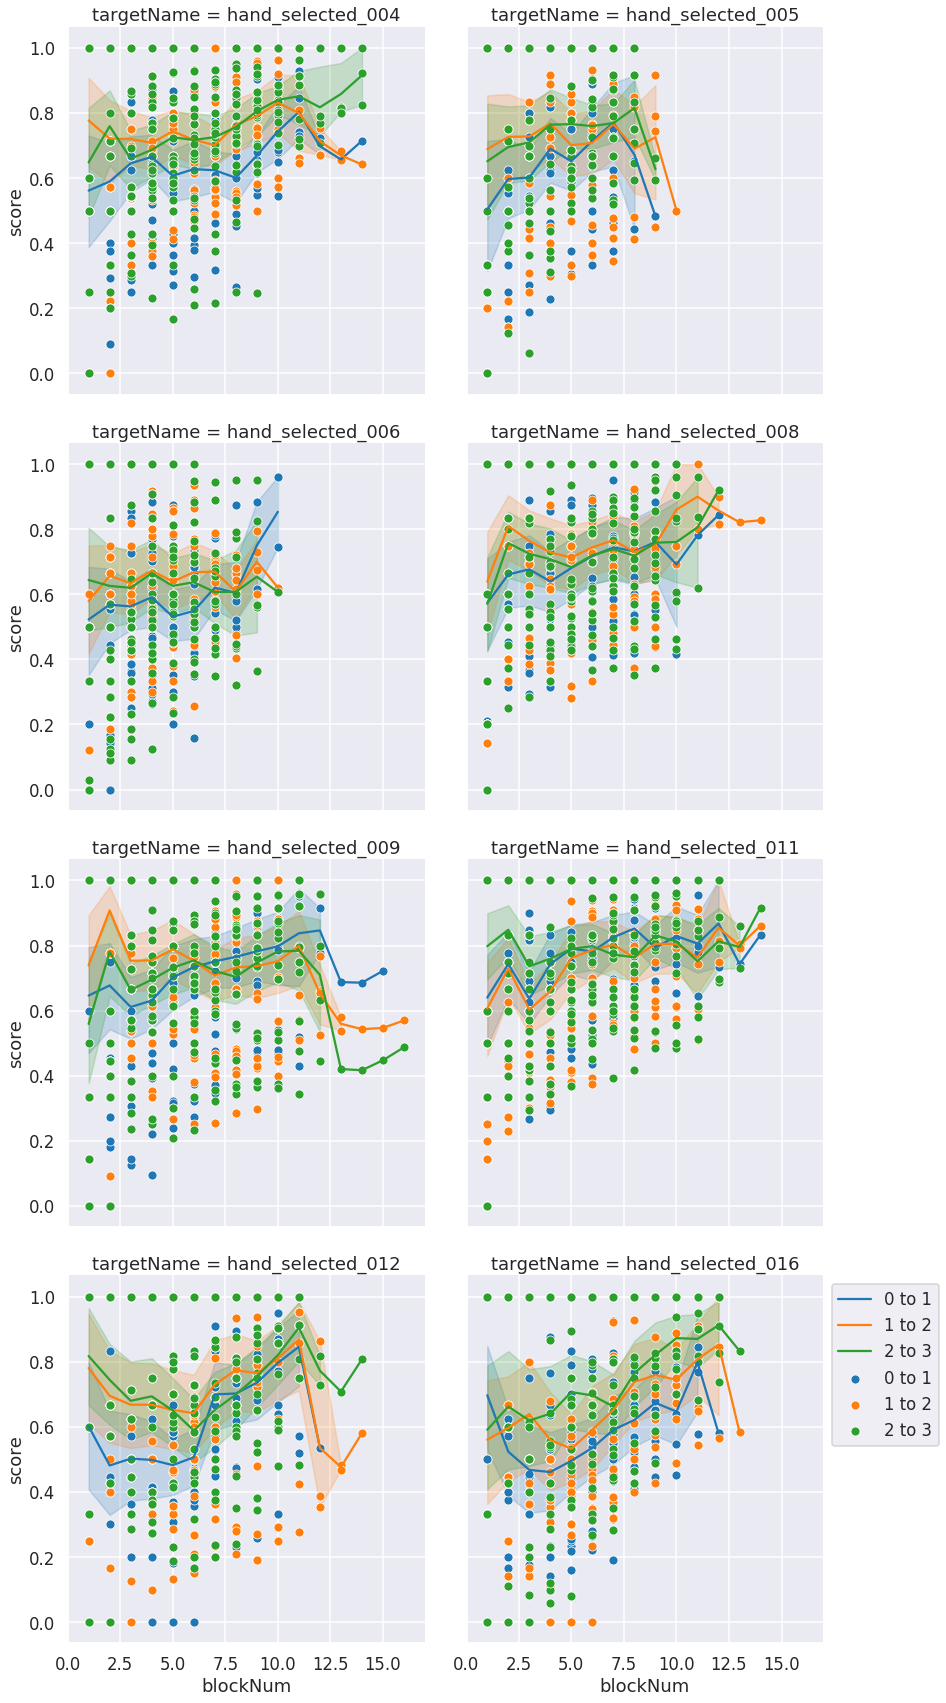

In [370]:
scores_sample = scores_df[scores_df.reps.isin(['0 to 1','1 to 2','2 to 3'])]

g = sns.FacetGrid(scores_sample, col="targetName", col_wrap=2, height=6, hue="reps")
g.map(sns.lineplot, "blockNum", "score");
g.map(sns.scatterplot, "blockNum", "score");
plt.legend(bbox_to_anchor=(1.0,1))

In [310]:
# Label pairs of repetitions by amount of overlap

def same_diff_from_jaccard(j):
    if np.isnan(j):
        return 'no values'
    elif j==1:
        return 'same'
    elif j==0:
        return 'no overlap'
    else:
        return 'overlap'
    
v_s = np.vectorize(same_diff_from_jaccard)
    
scores_df['samediff'] = v_s(scores_df.score)

In [357]:
scores_sample = scores_df[(scores_df.targetName==targets[0]) & (scores_df.reps.isin(['0 to 1','1 to 2','2 to 3']))]

# g = sns.FacetGrid(scores_sample, col="reps", col_wrap=2, height=6, hue="samediff")
# g.map(sns.barplot, "blockNum", );
# plt.legend(bbox_to_anchor=(1.0,1))

In [356]:
scores_df.groupby(['targetName','blockNum','reps'])['samediff'].value_counts()

targetName         blockNum  reps    samediff  
hand_selected_004  1         0 to 0  same          26
                                     no value      23
                             0 to 1  no value      23
                                     same          12
                                     no overlap     9
                                     overlap        5
                             0 to 2  no value      23
                                     same          13
                                     no overlap     9
                                     overlap        4
                             0 to 3  no value      23
                                     same          13
                                     no overlap    10
                                     overlap        3
                             1 to 1  same          26
                                     no value      23
                             1 to 2  no value      23
                                  

In [ ]:
# calculate all distances

# each small multiple is a target structure
# rows and columns are repetitions
# each value is a within participant, within structure, within action index, across repetition distance
# each layer is an action
targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
reps = np.sort(df['repetition'].unique())

n_targets = df['targetName'].nunique()
n_ppts = df['gameID'].nunique()
n_reps = df['repetition'].nunique()
n_grid_squares = 13*18

max_actions = df['numBlocks'].max()

dfic = dfi[['targetName','gameID','blockNum','condition','repetition','flatDiscreteWorld']]
dfic = dfic[dfic.condition=='repeated']

n_rows = n_reps
n_cols = n_reps

all_dists = np.zeros((n_targets, n_ppts, max_actions, n_rows, n_cols))

df_dists = pd.DataFrame(columns=['target', 'participant', 'block_num','rep_a','rep_b','dist'])

for t in range(0, n_targets):
    for p in range(0, n_ppts):
        for a in range(0, max_actions):
            for rep_a in range (0, n_rows): # row dim
                for rep_b in range (0, n_cols): # col dim
                    world_a = all_worlds[t,p,a,rep_a,:]
                    world_b = all_worlds[t,p,a,rep_b,:]
                    all_dists[t,p,a,rep_a,rep_b] = scoring.get_jaccard(world_a,world_b)
#                     df_dists = df_dists.append({'target': t,
#                                     'participant': p, 
#                                     'block_num': a,
#                                     'rep_a': rep_a,
#                                     'rep_b': rep_b,
#                                     'dist':scoring.get_jaccard(world_a,world_b)}, ignore_index=True)

In [ ]:
v_jaccard = np.vectorize(scoring.get_jaccard)

In [ ]:
img = plt.matshow(all_dists[1,3,8,:,:])
img.set_cmap('hot')
plt.axis('off')
plt.colorbar()

In [ ]:
for action in range(0, max_actions):
    action_dists = all_dists[1,:,action,:,:]
    img.set_cmap('hot')
    norm = plt.Normalize(0, 1)
    img = plt.matshow(np.nanmean(action_dists, axis=0), norm=norm)
    plt.axis('off')
    plt.colorbar()

In [ ]:
plt.set_cmap('hot')
cmap = plt.cm.get_cmap()
cmap.set_bad(color='green')
norm = plt.Normalize(0, 1)

for action in range(0, max_actions):
    img = plt.matshow(all_dists[0,5,action,:,:], cmap = cmap, norm=norm)
    plt.axis('off')
    plt.colorbar()

In [ ]:
#all_dists = (n_targets, n_ppts, max_actions, n_rows, n_cols)

In [ ]:
mean_dists_ppts = np.mean(all_dists[:,:,:,:,:], axis = 1)
mean_dists_ppts.shape

In [ ]:
df_dists['reps'] = df_dists.apply(lambda row: str(int(row.rep_a)) + ' to ' + str(int(row.rep_b)), axis = 1) 

In [ ]:
#fig = plt.figure(figsize=(10,6))
g = sns.FacetGrid(df_dists, row="target", hue="rep_a")
g.map(sns.scatterplot, "block_num", "dist")

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_dists, col="target", hue="reps", col_wrap=2, height=8)
g.map(sns.scatterplot, "block_num", "dist", s=15)
g.map(sns.lineplot, "block_num", "dist")


#g.map(sns.lineplot, "block_num", "dist")

In [ ]:
df_dists.reps.unique()

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 16)
sns.set(style="ticks", rc={"lines.linewidth": 1})
g = sns.FacetGrid(df_dists[(df_dists.target==0) & (df_dists.participant.isin(range(0,5)))], col="reps", hue="participant", col_wrap=4, height=6)
g.map(sns.scatterplot, "block_num", "dist", s=15)
g.map(sns.pointplot, "block_num", "dist")


In [ ]:
target = 0

fig = plt.figure(figsize=(10, 20))

for t in range(0, n_targets): 
    plt.subplot(4,2,t+1)
    plt.plot(mean_dists_ppts[t,:,0,1], label="1 to 2", color=line_cmap[0])
    #plt.plot(mean_dists_ppts[t,:,0,2], label="1 to 3", color=line_cmap[1])
    #plt.plot(mean_dists_ppts[t,:,0,3], label="1 to 4", color=line_cmap[2])
    plt.plot(mean_dists_ppts[t,:,1,2], label="2 to 3", color=line_cmap[3])
    #plt.plot(mean_dists_ppts[t,:,1,3], label="2 to 4", color=line_cmap[4])
    plt.plot(mean_dists_ppts[t,:,2,3], label="3 to 4", color=line_cmap[5])
plt.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

In [ ]:
target = 0

fig = plt.figure(figsize=(10, 20))

for t in range(0, n_targets): 
    plt.subplot(4,2,t+1)
    plt.plot(mean_dists_ppts[t,:,0,1], label="1 to 2", color=line_cmap[0])
    plt.scatter(x = all_dists[:,t,1,0,1], label="1 to 2", color=line_cmap[0])
    #plt.plot(mean_dists_ppts[t,:,0,2], label="1 to 3", color=line_cmap[1])
    #plt.plot(mean_dists_ppts[t,:,0,3], label="1 to 4", color=line_cmap[2])
    plt.plot(mean_dists_ppts[t,:,1,2], label="2 to 3", color=line_cmap[3])
    #plt.plot(mean_dists_ppts[t,:,1,3], label="2 to 4", color=line_cmap[4])
    plt.plot(mean_dists_ppts[t,:,2,3], label="3 to 4", color=line_cmap[5])
plt.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

At each time point
Relative proportion of full/partial/zero overlap
Each point has a distribution of Jaccard numbers


Over time, integration- area under curves

In [ ]:
target = 0

fig = plt.figure(figsize=(10, 20))

for t in range(0, n_targets): 
    plt.subplot(4,2,t+1)
    plt.plot(all_dists[t,1,:,0,1], label="1 to 2", color=line_cmap[0])
    plt.plot(all_dists[t,1,:,0,2], label="1 to 3", color=line_cmap[1])
    plt.plot(all_dists[t,1,:,0,3], label="1 to 4", color=line_cmap[2])
    plt.plot(all_dists[t,1,:,1,2], label="2 to 3", color=line_cmap[3])
    plt.plot(all_dists[t,1,:,1,3], label="2 to 4", color=line_cmap[4])
    plt.plot(all_dists[t,1,:,2,3], label="3 to 4", color=line_cmap[5])
plt.legend()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    


## Test Jaccard

In [ ]:
arr1, arr2 = np.zeros((13,18)), np.zeros((13,18))

arr1[0:2,6:10] = 1
plt.matshow(arr1)
print('arr1: ', np.count_nonzero(arr1))

arr2[0:2,7:11] = 1
print('arr2: ', np.count_nonzero(arr1))
plt.matshow(arr2)

print('Jaccard: ', scoring.get_jaccard(arr1,arr2))

In [ ]:
importlib.reload(rda)

all_dists, all_values = rda.rda_from_df(dfi[(dfi.gameID == ppts[0])], 
    row_col='repetition', 
    value_col='flatDiscreteWorld',
    small_multiple_col='targetName', 
    layer_col='blockNum')

In [ ]:
all_dists.shape

## Action-centric

In [70]:
# Make action dataframe
dfa = dfi[['gameID','trialNum','targetName','repetition','blockNum','condition','phase_extended','y_index','x_index','width_discrete','height_discrete']]
dfa = dfa.rename(columns = {'y_index':'y',
                            'x_index':'x',
                            'width_discrete':'w',
                            'height_discrete':'h'})

targets = np.sort(df['targetName'].unique())
ppts = np.sort(df['gameID'].unique())
extended_phases = ['pre', 'repetition 1', 'repetition 2', 'post']

In [466]:
ppts[11]

'1691-3673775e-bf17-46c9-b775-79afc1355b02'

In [654]:
# Choose which sequences to compare
truncating = False;

pptA = ppts[13]
targetA = targets[6]
phaseA = extended_phases[0]

pptB = ppts[13]
targetB = targets[6]
phaseB = extended_phases[3]

In [655]:
# Calculate distance matrix

# select two sets of actions e.g. compare one ppts attempts at one structure pre to post
s1 = dfa[(dfa.gameID == pptA) & (dfa.targetName == targetA) & (dfa.phase_extended == phaseA)]
s2 = dfa[(dfa.gameID == pptB) & (dfa.targetName == targetB) & (dfa.phase_extended == phaseB)]

# truncate to length of smaller set of actions
n_actions = min(len(s1),len(s2))

if truncating:
    s1 = s1.iloc[0:n_actions]
    s2 = s2.iloc[0:n_actions]

# apply distance metric between each 4-tuple in the sequence (but append s1 to s2)
s1_s2 = s1.append(s2)

dist_mat = s1_s2.apply(lambda r: 
            s1_s2.apply(lambda r2: 
                distance.euclidean(r[['x','y','w','h']],r2[['x','y','w','h']]),
                axis=1),
            axis=1)

A: left, top, B: right, bottom


(0.0, 900.0, 0.0, 900.0)

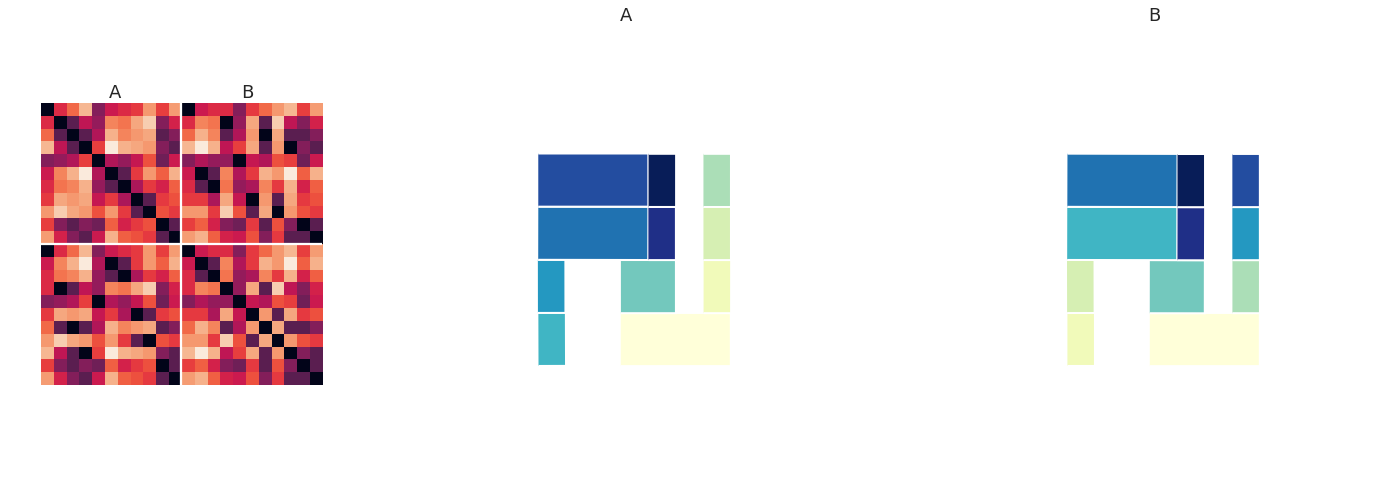

In [656]:
# Plot matrix and structures
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,8),
                       gridspec_kw={
                           'width_ratios': [1, 1.6, 1.6]})

ax[0].axis('off')
ax[0].imshow(dist_mat)
ax[0].axvline(x=(len(s1))-0.5, ymin=0, ymax=2*(len(s1))+1,color='white')
ax[0].axhline(y=(len(s1))-0.5, xmin=0, xmax=2*(len(s1))+1,color='white')
ax[0].set_title('A                     B')
print('A: left, top, B: right, bottom')

# fig2, ax2 = plt.subplots(figsize=(3,3))
drawing.draw_reconstruction_subplot(df=df[df.phase_extended == phaseA],gameID=pptA,targetName=targetA, ax=ax[1], n_colors = n_actions)
#draw_from_actions_subplot(dfa[(dfa.phase_extended == phaseA) & (dfa.gameID==pptA) & (dfa.targetName==targetA)], ax[1])
ax[1].set_title('A')
ax[1].axis('off')

# fig3, ax2 = plt.subplots(figsize=(3,3))
drawing.draw_reconstruction_subplot(df=df[df.phase_extended == phaseB],gameID=pptB,targetName=targetB, ax=ax[2], n_colors = n_actions)
# draw_from_actions_subplot(dfa[(dfa.phase_extended == phaseB) & (dfa.gameID==pptB) & (dfa.targetName==targetB)], ax[2])
ax[2].set_title('B')
ax[2].axis('off')

### 1. Directly compare internal structure of each sequence
Different measures are going to do different things here.
Flattening upper triangles and taking cosine distance

Text(0.5, 1.0, 'BB')

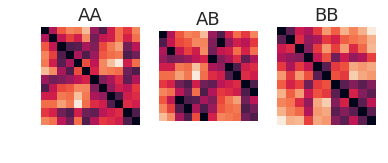

In [507]:
AA = dist_mat.values[0:len(s1),0:len(s1)]
AB = dist_mat.values[len(s1):,0:len(s1)]
BB = dist_mat.values[len(s1):,len(s1):]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(6,2))

ax[0].axis('off')
ax[0].imshow(AA) 
ax[0].set_title('AA')
ax[1].axis('off')
ax[1].imshow(AB)
ax[1].set_title('AB')
ax[2].axis('off')
ax[2].imshow(BB)
ax[2].set_title('BB')

In [513]:
assert (truncating == True) | (len(s1)==len(s2))

AA_triu = AA[np.triu_indices(n_actions, k=1)]
BB_triu = BB[np.triu_indices(n_actions, k=1)]

In [514]:
# Subtracting upper triangles
AA_triu-BB_triu

array([ 2.24264069,  2.08191463,  3.46944516,  2.        ,  1.77707744,
       -1.91519686, -5.21110255, -1.32455532, -0.50289862, -2.82842712,
        0.        ,  2.66867423,  1.39444872,  2.34846923, -1.64370883,
       -0.96643849, -1.        ,  0.38364861, -2.11208304, -0.82842712,
       -2.76393202, -2.70820393, -1.93674185, -0.78232998,  2.30958424,
        1.97929778, -4.5200421 ,  0.        , -3.38516481,  1.29216764,
        2.08191463,  3.54592627,  3.25834261, -3.09901951,  4.08276253,
       -0.41742431,  1.89494508,  1.60232527,  2.98715578, -2.        ,
       -0.28614529,  2.21110255, -0.81024968, -0.29179607, -3.87977681,
        1.16227766,  1.2946785 ,  3.38516481, -0.37893738, -0.86658468,
        2.17157288,  2.47213595,  0.        ,  1.        ,  3.38516481])

In [515]:
# Cosine distance between upper triangles
distance.cosine(AA_triu, BB_triu)

0.09154345339120806

### 2. Detect block-diagonal structure
Not sure how to go about this
Clustering?

Wait until we are using chunkier structures

### 3. Looking at between-sequence distances. Find measure of similarity that takes into account the fact that people might make the same placement but at different times
Diagonal tells us if same action performed at same time.
Any off-diagonals should be taken into account but downweighted in some way

What does it mean to have a high score < 1 (less than max) here? 'Very similar action' not particularly meaningful here

In [516]:
AB

array([[0.        , 4.24264069, 6.32455532, 7.21110255, 7.        ,
        8.48528137, 3.74165739, 2.        , 5.        , 6.70820393,
        5.65685425, 7.21110255],
       [2.        , 4.69041576, 6.        , 6.32455532, 7.28010989,
        7.21110255, 3.16227766, 0.        , 3.60555128, 5.        ,
        4.47213595, 5.65685425],
       [4.24264069, 0.        , 4.69041576, 5.83095189, 5.        ,
        7.34846923, 2.82842712, 4.69041576, 5.        , 6.70820393,
        5.09901951, 6.78232998],
       [3.74165739, 2.82842712, 3.16227766, 3.74165739, 4.58257569,
        5.09901951, 0.        , 3.16227766, 4.12310563, 5.38516481,
        2.44948974, 4.24264069],
       [5.        , 5.        , 7.        , 6.70820393, 8.60232527,
        7.        , 4.12310563, 3.60555128, 0.        , 2.        ,
        5.        , 5.38516481],
       [6.70820393, 6.70820393, 7.81024968, 7.        , 9.69535971,
        6.70820393, 5.38516481, 5.        , 2.        , 0.        ,
        5.38516481,

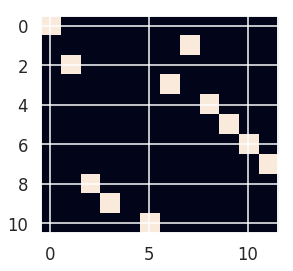

In [517]:
fig = plt.figure()
plt.imshow(AB == 0)

In [518]:
def exp_decay(x):
    return np.e**(-0.5 * (x/1)**2)

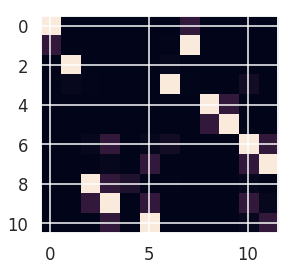

In [519]:
AB_filtered = np.vectorize(exp_decay)(AB)
fig = plt.figure()
plt.imshow(AB_filtered)

In [456]:
AB_filtered

array([[1.00000000e+00, 1.92874985e-22, 6.47023493e-26, 2.44260074e-36,
        1.03770332e-53, 5.10908903e-12, 2.44260074e-36, 2.31952283e-16,
        7.78113224e-20, 2.93748211e-30],
       [7.78113224e-20, 4.53999298e-05, 1.35335283e-01, 4.53999298e-05,
        1.71390843e-15, 1.52299797e-08, 5.74952226e-19, 1.80485139e-35,
        5.38018616e-32, 1.80485139e-35],
       [2.93748211e-30, 1.71390843e-15, 4.53999298e-05, 1.35335283e-01,
        4.53999298e-05, 5.10908903e-12, 1.52299797e-08, 6.81355682e-46,
        1.80485139e-35, 5.38018616e-32],
       [1.24794646e-47, 7.28129018e-33, 1.71390843e-15, 4.53999298e-05,
        1.35335283e-01, 1.92874985e-22, 4.53999298e-05, 2.89464031e-63,
        6.81355682e-46, 1.80485139e-35],
       [3.77513454e-11, 1.92874985e-22, 5.74952226e-19, 1.92874985e-22,
        7.28129018e-33, 1.35335283e-01, 5.74952226e-19, 2.31952283e-16,
        6.91440011e-13, 2.31952283e-16],
       [2.31952283e-16, 2.74878501e-43, 9.22114642e-47, 3.48110684e-57,
   